In [41]:
##################################################################
# This Script:
#    - 
#    -
#    -

##################################################################
import iris
import os
import glob as sir_globington_the_file_gatherer
import datetime as datetime
import iris.coord_categorisation as cat
import sys
import time
import multiprocessing as mp
import iris.plot as iplt

# Set up path to root directory
root_fp = "/nfs/a319/gy17m2a/PhD/"
os.chdir(root_fp)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from warnings import simplefilter
warnings.filterwarnings("ignore", category =UserWarning,)

# Create path to files containing functions
sys.path.insert(0, root_fp + 'Scripts/GlobalFunctions')
from Spatial_plotting_functions import *
from Spatial_geometry_functions import *

trim_to_leeds = False

##################################################################
# Load necessary spatial data
##################################################################
# This is a square area surrounding Leeds
uk_gdf = create_uk_outline({'init' :'epsg:3857'})
gb_gdf = create_gb_outline({'init' :'epsg:3857'})
##################################################################

# Constraint to only load 
in_jja=iris.Constraint(time=lambda cell: 6 <= cell.point.month <= 8)

yrs_range = "1980_2001"
yrs= range(1987,1989)
resolution = '2.2km_regridded_12km' #2.2km, 12km, 2.2km_regridded_12km

### Establish the ensemble members
ems = [ '15']
yr= 1995
em = '15'
yr=1995
ddir = f"ProcessedData/TimeSeries/UKCP18_hourly/{resolution}/{yrs_range}/{em}/"

print(em, resolution, trim_to_leeds)
print(em, yr)

# ### Get a list of filenames for this ensemble member, for just JJA
if resolution == '2.2km':
    general_filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/{resolution}/{em}/{yrs_range}/pr_rcp85_land-cpm_uk_2.2km_{em}_1hr_{yr}*'
elif resolution == '12km':
      general_filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/{resolution}/{em}/{yrs_range}/pr_rcp85_land-rcm_uk_12km_{em}_day_*'
elif resolution == '2.2km_regridded_12km':
    general_filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/{resolution}/{em}/NearestNeighbour/{yrs_range}/rg_pr_rcp85_land-cpm_uk_2.2km_{em}_1hr_{yr}*'

filenames = []
for filename in sir_globington_the_file_gatherer.glob(general_filename):
    filenames.append(filename)
print(f"loading {len(filenames)} files")

# ### Load in the data
monthly_cubes_list = iris.load(filenames, in_jja)
print(len(monthly_cubes_list))

for cube in monthly_cubes_list:
     for attr in ['creation_date', 'tracking_id', 'history', 'Conventions']:
            if attr in cube.attributes:
                del cube.attributes[attr]

# ### Concatenate cubes into one
model_cube = monthly_cubes_list.concatenate_cube()      

### Remove ensemble member dimension
model_cube = model_cube[0,:,:,:]

# ### Trim to UK
if resolution  == '2.2km':
    model_cube = trim_to_bbox_of_region_regriddedobs(model_cube, gb_gdf)
else:
    model_cube = trim_to_bbox_of_region_obs(model_cube, gb_gdf)

# ### Get the mask
print("getting mask")
if resolution =='2.2km':
    gb_mask = np.load("/nfs/a319/gy17m2a/PhD/datadir/UKCP18_2.2km_GB_Mask.npy")
else:
    gb_mask = np.load("/nfs/a319/gy17m2a/PhD/datadir/UKCP18_12km_GB_Mask.npy")
masked_cube_data = model_cube * gb_mask[np.newaxis, :, :]

# APPLY THE MASK
reshaped_mask = np.tile(gb_mask, (model_cube.shape[0], 1, 1))
reshaped_mask = reshaped_mask.astype(int)
reversed_array = ~reshaped_mask.astype(bool)

# Mask the cube
model_masked_cube = iris.util.mask_cube(model_cube, reversed_array)



15 2.2km_regridded_12km False
15 1995
loading 3 files
3
getting mask


In [40]:
##################################################################
# Load necessary spatial data
##################################################################
# This is a square area surrounding Leeds
leeds_at_centre_gdf = create_leeds_at_centre_outline({'init' :'epsg:3857'})
uk_gdf = create_uk_outline({'init' :'epsg:3857'})
gb_gdf = create_gb_outline({'init' :'epsg:3857'})

resolution = '12km'
years= range(1990,2015)
year = 1995

# Create directory to store outputs in
if resolution =='1km':
    ddir = f"ProcessedData/TimeSeries/CEH-GEAR/{resolution}/"
else:
    ddir = f"ProcessedData/TimeSeries/CEH-GEAR/{resolution}/NearestNeighbour/"
if not os.path.isdir(ddir):
    os.makedirs(ddir)

filenames =[]
# Create filepath to correct folder using correct resolution
if resolution == '1km': 
    general_filename = f'datadir/CEH-GEAR/CEH-GEAR_reformatted/rf_CEH-GEAR-1hr_{year}*'   
elif resolution == '2.2km':
    general_filename = f'datadir/CEH-GEAR/CEH-GEAR_regridded_2.2km/NearestNeighbour/rg_CEH-GEAR-1hr_{year}*'
elif resolution == '12km':
    general_filename = f'datadir/CEH-GEAR/CEH-GEAR_regridded_12km/NearestNeighbour/rg_CEH-GEAR-1hr_{year}*'
print(general_filename)

# Find all files in directory which start with this string
for filename in glob.glob(general_filename):
    filenames.append(filename)
print(len(filenames))

monthly_cubes_list = iris.load(filenames, in_jja)    
#print(monthly_cubes_list)

# Concatenate the cubes into one
print('Concatenating cube')
obs_cube = monthly_cubes_list.concatenate_cube()     
print(obs_cube.shape) 

########################################################################
########################################################################
# ### Get the mask
########################################################################
########################################################################
print("getting mask")
if resolution =='2.2km':
    obs_cube = trim_to_bbox_of_region_regriddedobs(obs_cube, gb_gdf)
    gb_mask = np.load("/nfs/a319/gy17m2a/PhD/datadir/UKCP18_2.2km_GB_Mask.npy")
elif resolution == '1km':
    obs_cube = trim_to_bbox_of_region_regriddedobs(obs_cube, gb_gdf)
    gb_mask = np.load("/nfs/a319/gy17m2a/PhD/datadir/UKCP18_1km_GB_Mask.npy")
else:
    obs_cube = trim_to_bbox_of_region_obs(obs_cube, gb_gdf)
    gb_mask = np.load("/nfs/a319/gy17m2a/PhD/datadir/UKCP18_12km_GB_Mask.npy")
masked_cube_data = obs_cube * gb_mask[np.newaxis, :, :]


print(obs_cube.shape) 

# APPLY THE MASK
reshaped_mask = np.tile(gb_mask, (obs_cube.shape[0], 1, 1))
reshaped_mask = reshaped_mask.astype(int)
reversed_array = ~reshaped_mask.astype(bool)

# Mask the cube
obs_masked_cube = iris.util.mask_cube(obs_cube, reversed_array)

########################################################################
########################################################################
# Get time values
########################################################################
########################################################################
#iplt.contourf(masked_cube[10])
# plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

# Get rid of negative values
compressed = obs_masked_cube.data.compressed()
print(compressed.shape[0])


datadir/CEH-GEAR/CEH-GEAR_regridded_12km/NearestNeighbour/rg_CEH-GEAR-1hr_1995*
12
Concatenating cube
(2208, 112, 82)
getting mask
(2208, 103, 74)
3550464


In [42]:
test_data_model = model_masked_cube.data
test_data_model.shape

(2160, 103, 74)

In [43]:
test_data_obs = obs_masked_cube.data
test_data.shape

(2208, 112, 82)

In [22]:
test_data_flat = test_data.flatten()

In [46]:
test_data_model.shape

(2160, 103, 74)

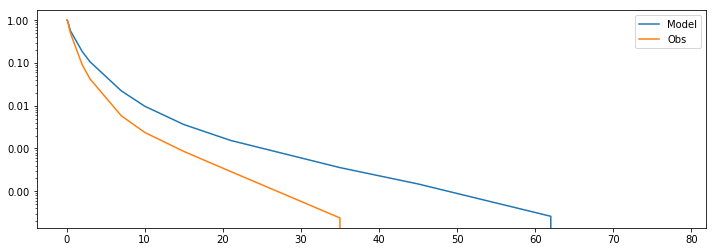

In [47]:
import matplotlib.ticker as ticker
bins_i_want  =  [0, 0.05, 0.1, 0.5,2, 3, 7, 10,15, 21, 35,45, 62, 78]

fig, ax = plt.subplots(figsize=(12,4))
# model_data =model_data[~np.isnan(model_data)]
model_data = test_data_model.flatten()
model_data = model_data[model_data >= 0.1]
model_count, bins_count = np.histogram(model_data, bins=bins_i_want)
model_pdf = model_count / sum(model_count)
model_cdf = np.cumsum(model_pdf)
model_reversed_cdf = 1 - model_cdf
ax.plot(bins_count[1:], model_reversed_cdf, label="Model")

obs_data = test_data_obs.flatten()
# obs_data = obs_data[~np.isnan(obs_data)]
obs_data = obs_data[obs_data >= 0.1]
obs_count, bins_count = np.histogram(obs_data, bins=bins_i_want)
obs_pdf = obs_count / sum(obs_count)
obs_cdf = np.cumsum(obs_pdf)
obs_reversed_cdf = 1 - obs_cdf
ax.plot(bins_count[1:], obs_reversed_cdf, label="Obs")

ax.legend()
ax.set_yscale('log')

ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False))
# ax.get_yaxis().set_major_formatter(
#     matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
